Import stuff and initialize global parameters.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D
from keras.models import Sequential
from common import extract_training_data_as_stacked
from sklearn.metrics import explained_variance_score

IMAGE_SIZE = (64, 64, 3)

Using TensorFlow backend.


# Convolutional network
Reading data as bundles and creating initial model.

In [2]:
images, labels = extract_training_data_as_stacked("Data/20171029-201949.h264.avi", 
                                                  "Data/20171029-201949.h264.csv", 
                                                  IMAGE_SIZE)

In [3]:
y_train = labels.as_matrix(columns=labels.columns[1: -1])
y_train.shape

(1741, 3)

In [4]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 12)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(Flatten())
    model.add(Dense(3, activation='linear'))

    model.compile(loss="mse", optimizer="adam")    
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        3488      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        9248      
__________

In [5]:
history = model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

Train on 1671 samples, validate on 70 samples
Epoch 1/10
1671/1671 [==============================] - 34s - loss: 0.1446 - val_loss: 0.1988
Epoch 2/10
1671/1671 [==============================] - 34s - loss: 0.0726 - val_loss: 0.2751
Epoch 3/10
1671/1671 [==============================] - 36s - loss: 0.0543 - val_loss: 0.3281
Epoch 4/10
1671/1671 [==============================] - 34s - loss: 0.0457 - val_loss: 0.2592
Epoch 5/10
1671/1671 [==============================] - 29s - loss: 0.0423 - val_loss: 0.3160
Epoch 6/10
1671/1671 [==============================] - 31s - loss: 0.0379 - val_loss: 0.4281
Epoch 7/10
1671/1671 [==============================] - 34s - loss: 0.0440 - val_loss: 0.2659
Epoch 8/10
1671/1671 [==============================] - 31s - loss: 0.0342 - val_loss: 0.2358
Epoch 9/10
1671/1671 [==============================] - 29s - loss: 0.0306 - val_loss: 0.2380
Epoch 10/10
1671/1671 [==============================] - 33s - loss: 0.0299 - val_loss: 0.2758


In [6]:
test_images, test_labels = extract_training_data_as_stacked("Data/20171029-201639.h264.avi", 
                                                            "Data/20171029-201639.h264.csv", 
                                                            IMAGE_SIZE)

prediction = model.predict(test_images)

### Convolutional network results
Testing prediction printout and graphs.

In [7]:
prediction

array([[ 0.15940252,  0.09587426,  1.07392311],
       [ 0.14391932,  0.08222517,  1.06870341],
       [ 0.12104919,  0.06764018,  1.09598768],
       ..., 
       [ 0.49170849,  0.06120233,  1.04867303],
       [ 0.24555784,  0.04037546,  1.0335561 ],
       [-0.04584796,  0.03750132,  0.92405033]], dtype=float32)

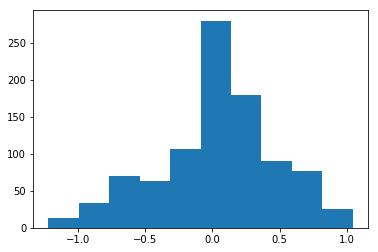

In [8]:
plt.hist(prediction[:, 0])
plt.show()

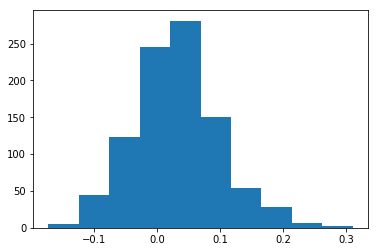

In [9]:
plt.hist(prediction[:, 1])
plt.show()

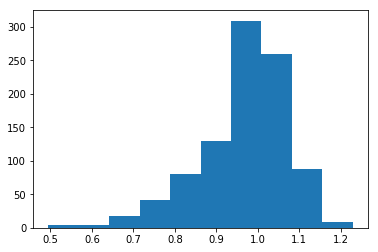

In [10]:
plt.hist(prediction[:, 2])
plt.show()

### Result analysis
Explained variance etc.

Firstly clip incorrect values back into known bounds. Afterwards find the explained variance.

In [11]:
validation_labels = test_labels.as_matrix(columns=test_labels.columns[1: -1])

clipped_prediction = np.zeros_like(prediction)
clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)

print(validation_labels.shape)
print(clipped_prediction.shape)

(939, 3)
(939, 3)


In [12]:
explained_variance_score(validation_labels, clipped_prediction)

0.10358442480994283

## K fold cross validation

In [ ]:
from common import run_kfold_cross_val

# Concatenate both videos
total_images = np.concatenate((images, test_images), axis=0)
total_labels = np.concatenate((labels, test_labels), axis=0)

total_y_train = total_labels[:, 1:-1]

results = run_kfold_cross_val(create_model, total_images, total_y_train)
print(results)
print(results.mean())
print(np.median(results))

## Saving model
Saves the model into a file and loads it again.

In [13]:
from keras.models import load_model

model.save('conv_dense.h5')
del model
model = load_model('conv_dense.h5')

Testing out model saving.

In [14]:
prediction = model.predict(test_images)

clipped_prediction = np.zeros_like(prediction)
clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)

explained_variance_score(validation_labels, clipped_prediction)

0.10358442480994283

It werks.